In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from plotnine import *

## Utility functions to parse experiment metadata

In [3]:
def parse_barcodes(bcfile, bc_id='BC'):
    res = {}
    with open(bcfile, 'r') as fi:
        for line in fi:
            fields = line.strip().split(',')
            if fields[0].startswith(bc_id):
                res[fields[0]] = fields[1]
    return res


def parse_exp_config(expfile, bc_dict):
    res = []
    fieldnames = ['id', 'sample', 'cond', 'barcode', 'size', 'region', 'Qbit', 'conc', 'dilution']
    with open(expfile) as fi:
        reader = csv.DictReader(fi, fieldnames=fieldnames)
        for rec in reader:
            if rec['id']:
                res.append({
                    'sample': rec['sample'],
                    'bc_id': rec['barcode'],
                    'bc_seq': bc_dict[rec['barcode']],
                    'temp': int(rec['cond'][:2]),
                    'bcm': '+' in rec['cond'],
                })
    return pd.DataFrame.from_records(res)

## Read the counts table

This is bacterial mRNA-Seq with samples at 4 different temperatures with or without the addition of BCM. Each condition is sequenced in triplicates. And we are interested in `5'UTRs` transcription levels.

In [7]:
bc_dict = parse_barcodes('../../data/Lexogen_Sense_RNA-Seq.csv')
exp_df = parse_exp_config('../../data/2017-03-09_NextSeq.csv', bc_dict)
agg_utr = pd.read_csv('../../data/utr.counts.csv')
agg_utr

,Unnamed: 0,gene,TSS,end,start,UTR_length,utr_counts,sample
0,0,C0343,2818676,2818728,2818676,52,4,utRho01
1,1,aaeB,6776526,6776526,6776376,150,20,utRho01
2,2,aaeR,6778762,6779040,6778762,278,136,utRho01
3,3,aaeX,6778860,6778860,6778674,186,170,utRho01
4,4,aat,1854920,1854920,1854864,56,32,utRho01
...,...,...,...,...,...,...,...,...
71575,2381,zraP,8403424,8403424,8403376,48,2,utRho30
71576,2382,zraS,8403810,8403852,8403810,42,82,utRho30
71577,2383,zupT,6364866,6365100,6364866,234,366,utRho30
71578,2384,zur,8520282,8520282,8520006,276,628,utRho30


## Normalize to `UTR` length

In [8]:
def normalize(df, edf, columns=None):
    '''
    Prepares the UTR dataframe (`df`) for log transformation.
    
    Adds experiment metadata from `edf`.
    Adds pseudocounts to `utr_counts` and `UTR_length`.
    Normalizes counts to UTR length.
    '''
    def pseudo_counts(x):
        return x + 1 if x == 0 else x

    df = df.merge(edf, how='left', on='sample')
    if columns is not None:
        df = df[columns]
    # Add pseudocounts to allow log transform later
    df['utr_counts'] = df['utr_counts'].apply(pseudo_counts)
    df['UTR_length'] = df['UTR_length'].apply(pseudo_counts)
    df['utr_norm'] = df['utr_counts'] / df['UTR_length']
    return df

In [9]:
columns = ['gene', 'TSS', 'start', 'end', 'UTR_length',
               'utr_counts', 'sample', 'bcm', 'temp']
utr = normalize(agg_utr, exp_df, columns)
utr

,gene,TSS,start,end,UTR_length,utr_counts,sample,bcm,temp,utr_norm
0,C0343,2818676,2818676,2818728,52,4,utRho01,False,10,0.076923
1,aaeB,6776526,6776376,6776526,150,20,utRho01,False,10,0.133333
2,aaeR,6778762,6778762,6779040,278,136,utRho01,False,10,0.489209
3,aaeX,6778860,6778674,6778860,186,170,utRho01,False,10,0.913978
4,aat,1854920,1854864,1854920,56,32,utRho01,False,10,0.571429
...,...,...,...,...,...,...,...,...,...,...
71575,zraP,8403424,8403376,8403424,48,2,utRho30,True,51,0.041667
71576,zraS,8403810,8403810,8403852,42,82,utRho30,True,51,1.952381
71577,zupT,6364866,6364866,6365100,234,366,utRho30,True,51,1.564103
71578,zur,8520282,8520006,8520282,276,628,utRho30,True,51,2.275362


## Notation

`X` : data (features)
`Y` : predicted value

## `-BCM` samples

From `scikit-learn` docs:

Standardize features by removing the mean and scaling to unit variance

The standard score of a sample `x` is calculated as:

`z = (x - u) / s`

where `u` is the mean of the training samples or zero if `with_mean=False`, and `s` is the standard deviation of the training samples or one if `with_std=False`.

In [12]:
# build expression matrix
X = pd.DataFrame()
samples = []

for sample in set(utr['sample']):
    mask = (utr['sample']==sample) & (utr['bcm']==False)
    if not utr[mask].empty:
        X[sample] = utr[mask]['utr_norm'].values
        samples.append(sample)
    
# Same as .fit() and then .transform()
X_std = StandardScaler().fit_transform(X.values.T)
X_std

array([[-0.41182215, -0.35767468,  0.89567674, ..., -0.35521186,
         1.25630607, -0.56361468],
       [ 0.32677193, -0.2821096 , -1.55450278, ...,  0.5837574 ,
        -0.35981582,  0.27105777],
       [-0.41182215, -0.35767468, -0.451922  , ..., -0.38672089,
        -1.10689103, -0.47508882],
       ...,
       [-0.41182215, -0.35767468,  1.67156692, ...,  0.52073933,
         1.89284464, -0.26009743],
       [-0.41182215, -0.35767468,  1.18153101, ..., -1.16499407,
        -0.96586152, -0.60155434],
       [ 1.18622686, -0.35767468,  0.77316776, ..., -0.02121608,
         0.19667898,  0.59986813]])

## Principal Component Analisys (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the `SVD`.

The resulting components are ranked by the amount of variance explained in the data.

In [14]:
sklearn_pca = sklearnPCA(n_components=10)
Y = sklearn_pca.fit_transform(X_std)
print(Y)
print(sklearn_pca.explained_variance_)
print(sklearn_pca.explained_variance_ratio_)

[[-1.84180228e+01  3.85455760e+01  1.92714166e+01  6.26492351e+00
   1.86267009e+00  5.30749058e+00 -6.67070495e+00  3.99260993e+00
   2.66448186e+01  5.31618792e-01]
 [-9.78874751e+00 -2.54150007e+01  1.56823598e+01 -6.96971149e+00
  -3.27985907e+00 -1.34188260e+01 -7.40965258e+00  3.12682974e+01
  -2.03404727e+00 -3.63381541e+00]
 [ 3.54256587e+01 -4.56606239e-01 -6.99848301e+00 -1.99915608e+01
  -1.59964938e+01  2.27071931e+01 -2.02312021e+01 -1.06909320e+00
   1.76973752e-01 -1.75425170e+00]
 [ 9.29415499e-01 -6.18164499e+00 -1.72009951e+01 -3.90190886e+00
  -5.49493463e-01 -7.52610254e-01  1.34938215e+00  2.20760005e+00
  -1.01838153e-01  1.09447231e+01]
 [-1.56183019e+01  3.27010705e+01  1.57258209e+01  2.39271922e+00
  -1.24396235e+00 -3.60139174e-02 -2.84315780e+00 -2.24028420e+00
  -2.13476234e+01 -2.61147263e+00]
 [-7.99866732e+00  4.65800825e+00 -2.05751541e+01 -9.64108660e+00
  -3.11100542e+00 -6.44702476e+00  1.26195813e+01 -2.70665691e+00
   6.65875165e+00 -1.06594761e+01

## Aside: `ggplot` terminology

from: https://beanumber.github.io/sds192/lab-ggplot2.html

### Geometric Objects (geom)

Geometric objects or geoms are the actual marks we put on a plot. Examples include:

- points (`geom_point`, for scatter plots, dot plots, etc)
- lines (`geom_line`, for time series, trend lines, etc)
- boxplot (`geom_boxplot`, for, well, boxplots!)
- … and many more!

A plot should have at least one geom, but there is no upper limit. You can add a geom to a plot using the + operator.

### Aesthetic Mapping (aes)

In `ggplot2`, aesthetic means “something you can see”. Each aesthetic is a mapping between a visual cue and a variable. Examples include:

- position (i.e., on the x and y axes)
- color (“outside” color)
- fill (“inside” color)
- shape (of points)
- line type
- size

Each type of geom accepts only a subset of all aesthetics—refer to the geom help pages to see what mappings each geom accepts. Aesthetic mappings are set with the `aes()` function.

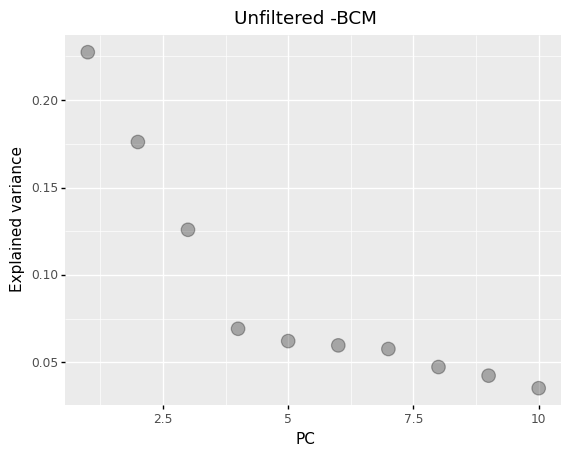

<ggplot: (8791823645832)>

In [17]:
vdf = pd.DataFrame()
vdf['PC'] = [(i+1) for i,x in enumerate(sklearn_pca.explained_variance_ratio_)]
vdf['var'] = sklearn_pca.explained_variance_ratio_

(ggplot(vdf, aes(x='PC', y='var'))
    + geom_point(size=5, alpha=0.3)
    + ylab('Explained variance')
    + ggtitle('Unfiltered -BCM')
)

In [18]:
pca_df = pd.DataFrame()
pca_df['cond'] = ['%doC' % exp_df[exp_df['sample']==sample]['temp'] for sample in samples]
pca_df['PC1'] = Y[:,0]
pca_df['PC2'] = Y[:,1]

pca_df

,cond,PC1,PC2
0,10oC,-18.418023,38.545576
1,44oC,-9.788748,-25.415001
2,51oC,35.425659,-0.456606
3,37oC,0.929415,-6.181645
4,10oC,-15.618302,32.701070
5,25oC,-7.998667,4.658008
6,25oC,-6.300806,3.739240
7,37oC,-16.377097,-14.205556
8,25oC,-8.530293,6.164390
9,37oC,-11.438467,-9.408411


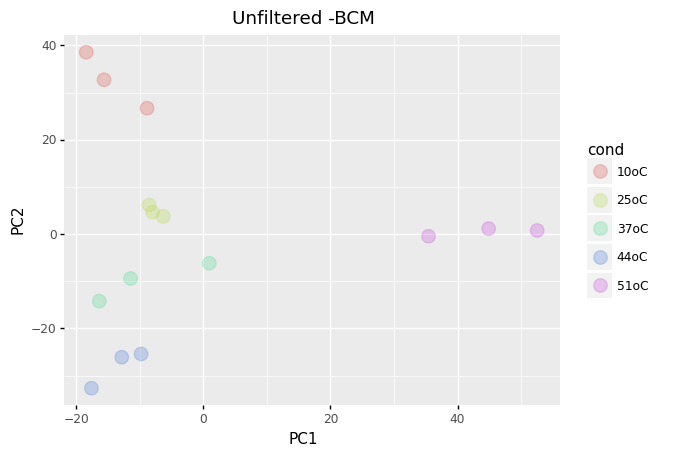

<ggplot: (8791823731321)>

In [19]:
(ggplot(pca_df, aes(x='PC1', y='PC2', color='cond'))
    + geom_point(size=5, alpha=0.3)
    + ggtitle('Unfiltered -BCM')
)

## `+BCM` samples

In [20]:
# build expression matrix

X = pd.DataFrame()
samples = []

for sample in set(utr['sample']):
    mask = (utr['sample']==sample) & (utr['bcm']==True)
    if not utr[mask].empty:
        X[sample] = utr[mask]['utr_norm'].values
        samples.append(sample)
    
X_std = StandardScaler().fit_transform(X.values.T)
X_std

array([[-0.52008826,  1.17547922,  1.15653883, ...,  0.62746817,
        -0.34979294,  0.22119731],
       [-0.52008826, -0.15449156,  0.23438162, ..., -0.93971649,
        -0.26849422, -0.32827371],
       [-0.52008826, -1.01091213, -1.23792619, ..., -0.93258482,
         0.76962785,  0.0732628 ],
       ...,
       [-0.52008826,  1.09487493,  0.30249551, ...,  0.21561418,
         0.24118619,  0.28459781],
       [-0.52008826,  1.43744317, -0.93927301, ..., -0.9914211 ,
        -0.4373454 , -1.05737949],
       [-0.52008826, -1.01091213, -0.61442217, ...,  1.67582378,
        -0.78130151, -0.85661123]])

In [21]:
sklearn_pca = sklearnPCA(n_components=10)
Y = sklearn_pca.fit_transform(X_std)

print(Y)
print(sklearn_pca.explained_variance_)
print(sklearn_pca.explained_variance_ratio_)

[[ 4.74180259e+01 -9.08036850e+00 -1.62634715e+01  1.35681210e-01
  -1.45628099e+00 -1.26294188e+00  2.74038292e+01 -1.12232518e+00
  -1.08444851e+01 -4.02323791e+00]
 [ 2.05065646e+01  5.18780897e+01  1.48239121e+01  1.99096312e+01
   1.78205917e+01 -2.77971883e+00  2.25903297e+00 -5.77262475e+00
   3.36518392e+00  1.42890617e+00]
 [-3.37130881e+01  1.45851207e+00 -1.50862874e+01 -7.44624740e+00
   4.59009537e+00 -3.41488872e+00 -1.13385653e+00  2.40747633e-01
   1.22180934e+00 -2.05261769e+00]
 [-8.78856974e+00 -1.96462669e+01  1.04786501e+01  2.71477743e+01
  -1.13018073e+01 -2.54687602e-01 -1.70625294e+00  8.31674727e-01
   5.79318851e+00 -2.08666240e+01]
 [ 5.29157260e+01 -1.04140908e+01 -1.44177855e+01  1.46101195e+00
   8.09263992e+00  5.08741562e+00 -2.46875550e+01  2.22325112e+00
  -1.18849767e+01 -2.91030154e+00]
 [-3.57625874e+01 -4.95493660e+00 -1.79735303e+01 -6.98976532e-01
   2.07800007e+01 -2.81147455e+00  1.15278649e+00 -3.43364181e+00
   4.53323771e+00 -3.65106073e+00

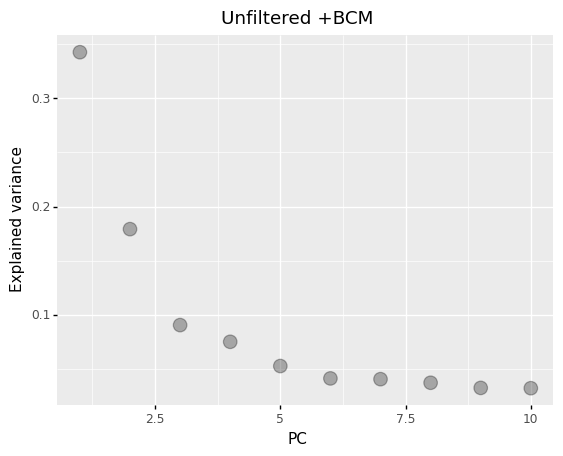

<ggplot: (8791823593741)>

In [23]:
vdf = pd.DataFrame()
vdf['PC'] = [(i+1) for i,x in enumerate(sklearn_pca.explained_variance_ratio_)]
vdf['var'] = sklearn_pca.explained_variance_ratio_

(ggplot(vdf, aes(x='PC', y='var'))
    + geom_point(size=5, alpha=0.3)
    + ylab('Explained variance')
    + ggtitle('Unfiltered +BCM')
)

In [24]:
pca_df = pd.DataFrame()
pca_df['cond'] = ['%doC' % exp_df[exp_df['sample']==sample]['temp'] for sample in samples]
pca_df['PC1'] = Y[:,0]
pca_df['PC2'] = Y[:,1]

pca_df

,cond,PC1,PC2
0,44oC,47.418026,-9.080368
1,51oC,20.506565,51.878090
2,10oC,-33.713088,1.458512
3,25oC,-8.788570,-19.646267
4,44oC,52.915726,-10.414091
5,10oC,-35.762587,-4.954937
6,44oC,39.683982,-6.487026
7,37oC,7.851762,-11.965814
8,25oC,-24.750981,-9.520820
9,37oC,-1.499140,-11.483680


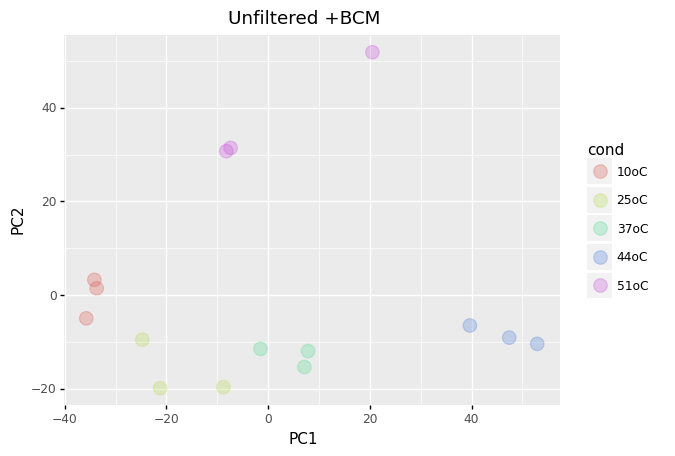

<ggplot: (8791823666014)>

In [26]:
(ggplot(pca_df, aes(x='PC1', y='PC2', color='cond'))
    + geom_point(size=5, alpha=0.3)
    + ggtitle('Unfiltered +BCM')
)